<Strong> Note to the reader: </Strong> This notebook currently calculates the cross correlation of the PanSTARRS SuperNova set with the LOWZ and CMASS galaxy catalogs from BOSS (SDSS). There are also some trouble shooting/data validation calculations along the way. </br>

Annotations about TreeCorr are taken from the documentation and all credit goes to Mike Jarvis. </br>

https://rmjarvis.github.io/TreeCorr/_build/html/overview.html </br>

V2: Create functions for easier readability and adaptability. 

-MT 6/15/20

#### List of changes/fixes that are not resolved: 
 
- Create Correlation creating function
- Make all queries at the start of the program --- PROGRESS
- Corr func asymptotes to .2 instead of zero? --- NEED TO DO 
- Theory calculuation --- NEED TO SWITCH TO DOING 

### Imports and formatting: 

In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image

In [2]:
#plt.switch_backend('agg') #For HEP, matplotlib x windows issues see python version for more usage 
import treecorr
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import os
import datetime

### Define notebook wide data paths to use:

In [3]:
#dataPath = '/Users/megantabbutt/CosmologyDataProducts/'
#dataPath = '/afs/hep.wisc.edu/home/tabbutt/private/CosmologyDataProducts/'

#testingProductsPath = "/Users/megantabbutt/Cosmology/Cosmology/SNe CrossCorrelations/VerificationTestingProducts/"

# Python has datename, savfig folder fields, usually don't save this code just for monkeying around... 
# If wanted to save some plots, should invoke this, and add text file to the folder with notes for that run 

#date = ' 05_29_20_12pm'

In [4]:
# Define the paths for local and HEP machines:
DATA_PATH = '/Users/megantabbutt/CosmologyDataProducts/'
#DATA_PATH = '/afs/hep.wisc.edu/home/tabbutt/private/CosmologyDataProducts/'

TESTING_PRODUCTS_PATH = "/Users/megantabbutt/Cosmology/Cosmology/SNe CrossCorrelations/VerificationTestingProducts/"
#TESTING_PRODUCTS_PATH = "/afs/hep.wisc.edu/home/tabbutt/public/Cosmology/SNe CrossCorrelations/VerificationTestingProducts/"

# Create the directory to save to and a file with info about this run:
DATE = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M")
CURRENT_DIRECTORY = DATE
TESTING_PRODUCTS_PATH = TESTING_PRODUCTS_PATH + CURRENT_DIRECTORY

os.mkdir(TESTING_PRODUCTS_PATH)

NOTES_NAME = "/RUNNING_NOTES_" + DATE + ".txt"
NOTES_PATH = TESTING_PRODUCTS_PATH + NOTES_NAME

### Define notebook wide data paths to use:

In [5]:
''' Writes a string to a file.
File name: NOTES_NAME, path: NOTES_PATH. These are defined at the beginning of the program.

@param str notes: A single string to be writen.
'''

def NotesToWrite(notes):
    NOTES = open(NOTES_PATH, "a")
    NOTES.write(notes)
    NOTES.write("\n \n")
    NOTES.close()

In [6]:
''' Creates a simple 2D count-count correlation function using TreeCorr. 

@param object DataCatalog: TreeCorr Catalog object for the data 
@param object RandCatalog: TreeCorr Catalog object for the Randoms 

'''

def AutoCorrelationFunction(DataCatalog, RandCatalog):
    nn = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
    nn.process(DataCatalog)
    
    rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
    rr.process(RandCatalog)
    
    dr = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
    dr.process(DataCatalog, RandCatalog)
    
    r = numpy.exp(nn.meanlogr)
    xi, varxi = nn.calculateXi(rr, dr)
    sig = numpy.sqrt(varxi)
    
    return r, xi, varxi, sig

### Start writing notes to textfile:
Write notes about:
- Steps completed in program
- plot made and saved to folder
- Amount of data points, randoms points in plots and data runs

In [7]:
# Write an opening note in the file:
NotesToWrite("Created Running notes file for tracking details about this run and products produced/saved")

 <hr style="height:3px"> 

## 0. Define the Queries that you want to run:

In [8]:
NotesToWrite("0. Define the Queries you want to run and write and randoms length:")

In [9]:
randsLength = 10**8
NotesToWrite("randsLength for PanSTARRS: " + str(randsLength))

In [10]:
# Pull in All PanSTARRS Data (with a good redshift): 

qry_PanSTARRS_Data_All = "SELECT ID, DEC, RA, zSN, zHost FROM PanSTARRSNEW WHERE (zSN > -999) || (zHost > -999)"
NotesToWrite("qry_PanSTARRS_Data_All" + " \n" + qry_PanSTARRS_Data_All)

qry_PanSTARRS_Data_Overlap = """SELECT ID, DEC, RA, zSN, zHost FROM PanSTARRSNEW WHERE (DEC > -20) 
    AND ((zSN > -999) OR (zHost > -999))"""
NotesToWrite("qry_PanSTARRS_Data_Overlap" + " \n" + qry_PanSTARRS_Data_Overlap)

qry_BOSS_Data_SouthAndNorthALL = "SELECT * FROM CMASSLOWZTOT_South UNION SELECT * FROM CMASSLOWZTOT_North"
NotesToWrite("qry_BOSS_Data_SouthAndNorthALL" + " \n" + qry_BOSS_Data_SouthAndNorthALL)

qry_BOSS_Rands_SouthAndNorthLimit = """SELECT * FROM CMASSLOWZTOT_South_rands 
    WHERE `index` IN (SELECT `index`FROM CMASSLOWZTOT_South_rands ORDER BY RANDOM() LIMIT 10000000) UNION 
    SELECT * FROM CMASSLOWZTOT_North_rands 
    WHERE `index`  IN (SELECT `index` FROM CMASSLOWZTOT_North_rands ORDER BY RANDOM() LIMIT 10000000)"""
NotesToWrite("qry_BOSS_Rands_SouthAndNorthLimit" + " \n" + qry_BOSS_Rands_SouthAndNorthLimit)

qry_CMASS_Rands_SampleLimit = """SELECT * FROM CMASS_South_rands 
    WHERE `index` IN (SELECT `index` FROM CMASS_South_rands ORDER BY RANDOM() LIMIT 10000000) UNION 
    SELECT * FROM CMASS_North_rands WHERE 
    `index` IN (SELECT `index` FROM CMASS_North_rands ORDER BY RANDOM() LIMIT 10000000)"""
NotesToWrite("qry_CMASS_Rands_SampleLimit" + " \n" + qry_CMASS_Rands_SampleLimit)


qry_LOWZ_Rands_SampleLimit = """SELECT * FROM LOWZ_South_rands 
    WHERE `index` IN (SELECT `index` FROM LOWZ_South_rands ORDER BY RANDOM() LIMIT 10000000) UNION 
    SELECT * FROM LOWZ_North_rands WHERE 
    `index` IN (SELECT `index` FROM LOWZ_North_rands ORDER BY RANDOM() LIMIT 10000000)"""
NotesToWrite("qry_LOWZ_Rands_SampleLimit" + " \n" + qry_LOWZ_Rands_SampleLimit)

 <hr style="height:3px"> 


## 1. Pull in and parse data:

note: There are 10 pointings for the PanSTARRS data, we will use all 10 for the Auto Correlation, but when we correlated to CMASS, we need to only use the 9 overlap with CMASS. --- IMPORTANT

In [11]:
NotesToWrite("1. Pull in and parse data")

#### PanSTARRS: 

In [12]:
connPAN = sqlite3.connect(DATA_PATH + 'PanSTARRS.db')
PanSTARRSNEW_GoodZ = pd.read_sql(qry_PanSTARRS_Data_All, con=connPAN)
NotesToWrite("PanSTARRSNEW_GoodZ Database (with 10 pointings) objects: " + str(len(PanSTARRSNEW_GoodZ)))
connPAN.close()
PanSTARRSNEW_GoodZ.head(3) # 1129 objects over 10 pointings 

,ID,DEC,RA,zSN,zHost
0,ps0909006,1.184831,333.9500,0.284,-999.0
1,ps0909010,-4.078911,37.1182,0.270,-999.0
2,ps0910017,-5.023289,35.2775,0.320,-999.0


#### CMASS/LOWZ:

In [13]:
connBOSS = sqlite3.connect(DATA_PATH + 'CMASS_and_LOWZ.db')
CMASSLOWZTOT_DF = pd.read_sql(qry_BOSS_Data_SouthAndNorthALL, con=connBOSS)
NotesToWrite("CMASSLOWZTOT_DF Database objects: " + str(len(CMASSLOWZTOT_DF)))
connBOSS.close()
CMASSLOWZTOT_DF.head(3) # 1.3 million objects

,index,RA,DEC,Z,NZ
0,0,195.071285,-0.590771,0.465648,0.000345
1,0,321.480329,9.973440,0.301401,0.000390
2,1,195.022992,-0.610999,0.565802,0.000319


#### Pull in the Randoms provided by CMASS:

In [ ]:
connBOSSRands = sqlite3.connect(DATA_PATH + 'CMASS_and_LOWZ_rands.db')
CMASSLOWZTOT_DF_rands = pd.read_sql(qry_BOSS_Rands_SouthAndNorthLimit, con=connBOSSRands)
CMASSLOWZTOT_DF_rands.to_json(DATA_PATH + "CMASSLOWZTOT_DF_rands")
NotesToWrite("CMASSLOWZTOT_DF_rands Database objects: " + str(len(CMASSLOWZTOT_DF_rands)))
connBOSSRands.close()
CMASSLOWZTOT_DF_rands.head(3)

 <hr style="height:3px"> 

## 2. Create the TreeCorr Catalogs of Data:

A set of input data (positions and other quantities) to be correlated.

A Catalog object keeps track of the relevant information for a number of objects to be correlated. The objects each have some kind of position (for instance (x,y), (ra,dec), (x,y,z), etc.), and possibly some extra information such as weights (w), shear values (g1,g2), or kappa values (k).

The simplest way to build a Catalog is to simply pass in numpy arrays for each piece of information you want included. 

> cat = treecorr.Catalog(ra=ra, dec=dec, g1=g1, g2=g2, ra_units='hour', dec_units='deg')

Other options for reading in from a file, using a config file, etc

In [ ]:
NotesToWrite("2. Create the TreeCorr Catalogs of Data:")

In [ ]:
cat_PanSTARRS_Full = treecorr.Catalog(ra=PanSTARRSNEW_GoodZ['RA'], dec=PanSTARRSNEW_GoodZ['DEC'], ra_units='degrees', dec_units='degrees')
NotesToWrite("Created cat_PanSTARRS_Full.")
cat_PanSTARRS_Full

 <hr style="height:3px"> 

## 3. Create the randoms for PanSTARRS
Include all ten pointings for now, can just exclude the pointing that isn't in CMASS when doing the CrossCorr </br>

Possibility to ask for mask eventually if we think that it is a limitation </br>

In [ ]:
NotesToWrite("3. Create the randoms for PanSTARRS. Include all 10 pointings, delete MD02 later.")

In [ ]:
ra_min_PanSTARRS = numpy.min(cat_PanSTARRS_Full.ra)
ra_max_PanSTARRS = numpy.max(cat_PanSTARRS_Full.ra)
dec_min_PanSTARRS = numpy.min(cat_PanSTARRS_Full.dec)
dec_max_PanSTARRS = numpy.max(cat_PanSTARRS_Full.dec)
print('PanSTARRS ra range = %f .. %f' % (ra_min_PanSTARRS, ra_max_PanSTARRS))
print('PanSTARRS dec range = %f .. %f' % (dec_min_PanSTARRS, dec_max_PanSTARRS))

rand_ra_PanSTARRS = numpy.random.uniform(ra_min_PanSTARRS, ra_max_PanSTARRS, randsLength)
rand_sindec_PanSTARRS = numpy.random.uniform(numpy.sin(dec_min_PanSTARRS), numpy.sin(dec_max_PanSTARRS), randsLength)
rand_dec_PanSTARRS = numpy.arcsin(rand_sindec_PanSTARRS)

#### Note: MD02 is the one that needs to be eliminated, not in CMASS footprint 

In [ ]:
# Got from a paper, need to cite it here:  https://arxiv.org/pdf/1612.05560.pdf

pointings = {"MD01": [035.875, -04.250], "MD03": [130.592, 44.317], "MD04": [150.000, 02.200], 
             "MD05": [161.917, 58.083], "MD06": [185.000, 47.117], "MD07": [213.704, 53.083], 
             "MD08": [242.787, 54.950], "MD09": [334.188, 00.283], "MD10": [352.312, -00.433], "MD02": [053.100, -27.800],}

In [ ]:
"""# Check how well the randoms cover the same space as the data

f1, (ax1a, ax2a, ax3a) = plt.subplots(1, 3, figsize=(20, 5))
ax1a.scatter(cat_PanSTARRS_Full.ra * 180/numpy.pi, cat_PanSTARRS_Full.dec * 180/numpy.pi, color='red', s=0.1, marker='x')
ax1a.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='blue', s=0.1)
ax1a.set_xlabel('RA (degrees)')
ax1a.set_ylabel('Dec (degrees)')
ax1a.set_title('Randoms on top of data')

# Repeat in the opposite order
ax2a.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='blue', s=0.1, marker='x')
ax2a.scatter(cat_PanSTARRS_Full.ra * 180/numpy.pi, cat_PanSTARRS_Full.dec * 180/numpy.pi, color='red', s=0.1)
ax2a.set_xlabel('RA (degrees)')
ax2a.set_ylabel('Dec (degrees)')
ax2a.set_title('Data on top of randoms')

# Zoom to look at coverage of randoms and reals
ax3a.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='blue', s=1, marker='x', label='rands')
ax3a.scatter(cat_PanSTARRS_Full.ra * 180/numpy.pi, cat_PanSTARRS_Full.dec * 180/numpy.pi, color='red', s=1, label='data')
ax3a.set_xlabel('RA (degrees)')
ax3a.set_ylabel('Dec (degrees)')
ax3a.set_title('Data on top of randoms_Zoom')
ax3a.legend(loc = "upper right")
ax3a.set_xlim(128, 133)
ax3a.set_ylim(42, 47)

plt.savefig(TESTING_PRODUCTS_PATH + "/PanSTARRS data and randoms")

plt.show()"""

In [ ]:
#NotesToWrite("Plotted: PanSTARRS data and randoms")

"The telescope illuminates a diameter of 3.3 degrees,  with low distortion, and mild vignetting at the edge of this illuminated region. The field of view is approximately 7 square degrees. The 8  meter  focal  length  atf/4.4  gives  an  approximate  10micron pixel scale of 0.258 arcsec/pixel."

7 square degrees --> r = 1.49 deg

In [ ]:
radius = (3.3/2) * numpy.pi / 180.0

maskRA = []
maskDEC = []
randoms_Lengths = []

for pointing in pointings: 
    
    print(pointings[pointing])
    center_dec = pointings[pointing][1] * numpy.pi / 180
    center_ra = pointings[pointing][0] * numpy.pi / 180

    angular_seps = numpy.arccos(numpy.cos(numpy.pi / 2 - center_dec) * numpy.cos(numpy.pi / 2 - rand_dec_PanSTARRS) + 
                                numpy.sin(numpy.pi / 2 - center_dec) * numpy.sin(numpy.pi / 2 - rand_dec_PanSTARRS) * 
                                numpy.cos(center_ra - rand_ra_PanSTARRS))

    ras_in_circle = rand_ra_PanSTARRS[angular_seps < radius]
    print(len(ras_in_circle))
    ras_in_circle = ras_in_circle * 180 / numpy.pi
    decs_in_circle = rand_dec_PanSTARRS[angular_seps < radius]
    print(len(decs_in_circle))
    decs_in_circle = decs_in_circle * 180 / numpy.pi
    
    maskRA.extend(ras_in_circle)
    maskDEC.extend(decs_in_circle)
    
    randoms_Lengths.append(len(ras_in_circle))
    
NotesToWrite("Populated pointings with randoms. Randoms per pointing: (1, 3-10, 2):"+ str(randoms_Lengths))

 <hr style="height:3px"> 

## 4. Make PanSTARRS Count-Count Auto Correlation Functions:

Typical Usage Pattern:

> nn = treecorr.NNCorrelation(config) 
<br>
nn.process(cat)     # For auto-correlation.
<br>
nn.process(cat1,cat2)   # For cross-correlation.
<br>
rr.process...           # Likewise for random-random correlations
<br>
dr.process...        # If desired, also do data-random correlations
<br>
rd.process...    # For cross-correlations, also do the reverse.
<br>
nn.write(file_name,rr,dr,rd)  # Write out to a file.
<br>
xi,varxi = nn.calculateXi(rr,dr,rd)  # Or get the correlation function directly.

In [ ]:
NotesToWrite("4. Make PanSTARRS Count-Count Auto Correlation Functions:")

In [ ]:
cat_rand_PanSTARRS_Full = treecorr.Catalog(ra=maskRA, dec=maskDEC, ra_units='degrees', dec_units='degrees')

r_PanSTARRS_Full, xi_PanSTARRS_Full, varxi_PanSTARRS_Full, sig_PanSTARRS_Full = AutoCorrelationFunction(cat_PanSTARRS_Full, 
                                                                                                        cat_rand_PanSTARRS_Full)

In [ ]:
# Plot the Correlation function:
plt.plot(r_PanSTARRS_Full, xi_PanSTARRS_Full, color='blue')
plt.plot(r_PanSTARRS_Full, -xi_PanSTARRS_Full, color='blue', ls=':')
plt.errorbar(r_PanSTARRS_Full[xi_PanSTARRS_Full>0], xi_PanSTARRS_Full[xi_PanSTARRS_Full>0], yerr=sig_PanSTARRS_Full[xi_PanSTARRS_Full>0], color='green', lw=0.5, ls='')
plt.errorbar(r_PanSTARRS_Full[xi_PanSTARRS_Full<0], -xi_PanSTARRS_Full[xi_PanSTARRS_Full<0], yerr=sig_PanSTARRS_Full[xi_PanSTARRS_Full<0], color='green', lw=0.5, ls='')
leg = plt.errorbar(-r_PanSTARRS_Full, xi_PanSTARRS_Full, yerr=sig_PanSTARRS_Full, color='blue')
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')
plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])

plt.savefig(TESTING_PRODUCTS_PATH + "/PanSTARRS Auto-Corr with PanSTARRS randoms")

plt.show()

In [ ]:
NotesToWrite("Plotted: PanSTARRS Auto-Corr with PanSTARRS randoms")

 <hr style="height:3px"> 

## 5. Make CMASS&LOWZ Count-Count Auto Correlation Functions:

Typical Usage Pattern:

> nn = treecorr.NNCorrelation(config) 
<br>
nn.process(cat)     # For auto-correlation.
<br>
nn.process(cat1,cat2)   # For cross-correlation.
<br>
rr.process...           # Likewise for random-random correlations
<br>
dr.process...        # If desired, also do data-random correlations
<br>
rd.process...    # For cross-correlations, also do the reverse.
<br>
nn.write(file_name,rr,dr,rd)  # Write out to a file.
<br>
xi,varxi = nn.calculateXi(rr,dr,rd)  # Or get the correlation function directly.

In [27]:
NotesToWrite("5. Make CMASS&LOWZ Count-Count Auto Correlation Functions:")

The CMASS plot should look like this paper's figure 1: </br>

https://arxiv.org/pdf/1607.03144.pdf

### 5.1 BOSS total AutoCorrelation Function

In [28]:
NotesToWrite("5.1 BOSS total AutoCorrelation Function")

In [29]:
cat_BOSS = treecorr.Catalog(ra=CMASSLOWZTOT_DF['RA'], dec=CMASSLOWZTOT_DF['DEC'], ra_units='degrees', dec_units='degrees')
cat_rand_BOSS = treecorr.Catalog(ra=CMASSLOWZTOT_DF_rands['RA'], dec=CMASSLOWZTOT_DF_rands['DEC'], ra_units='degrees', 
                                  dec_units='degrees')

In [30]:
NotesToWrite("Created cat_BOSS & cat_rand_BOSS.")

In [31]:
r_BOSS, xi_BOSS, varxi_BOSS, sig_BOSS = AutoCorrelationFunction(cat_BOSS, cat_rand_BOSS)

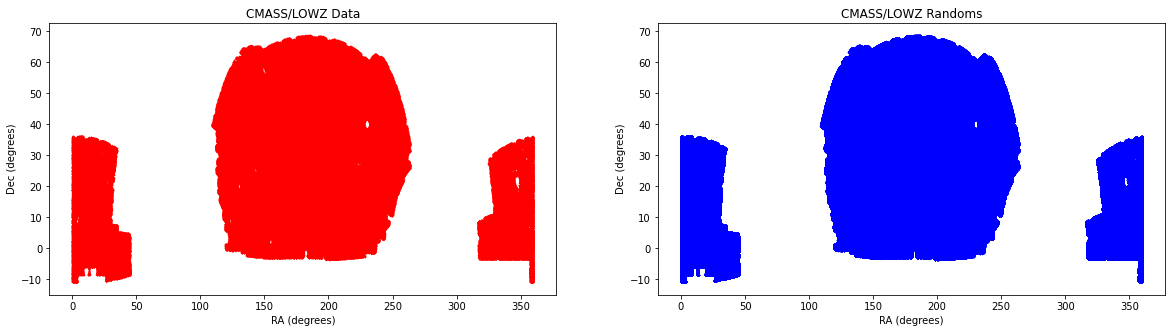

In [32]:
f3, (ax1c, ax2c) = plt.subplots(1, 2, figsize=(20, 5))

ax1c.scatter(cat_BOSS.ra * 180/numpy.pi, cat_BOSS.dec * 180/numpy.pi, color='red', s=0.1)
ax1c.set_xlabel('RA (degrees)')
ax1c.set_ylabel('Dec (degrees)')
ax1c.set_title('CMASS/LOWZ Data')

# Repeat in the opposite order
ax2c.scatter(CMASSLOWZTOT_DF_rands['RA'], CMASSLOWZTOT_DF_rands['DEC'], color='blue', s=0.1)
ax2c.set_xlabel('RA (degrees)')
ax2c.set_ylabel('Dec (degrees)')
ax2c.set_title('CMASS/LOWZ Randoms')

plt.savefig(TESTING_PRODUCTS_PATH + "/CMASS_LOWZ Data and Randoms")
plt.show()

In [33]:
NotesToWrite("Plotted: CMASS_LOWZ Data and Randoms")

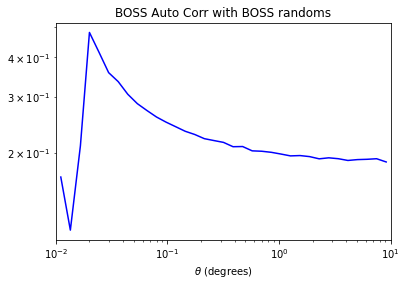

In [34]:
# Plot the autocorrelation function:

plt.plot(r_BOSS, xi_BOSS, color='blue')
plt.plot(r_BOSS, -xi_BOSS, color='blue', ls=':')
#plt.errorbar(r_BOSS[xi_BOSS>0], xi_BOSS[xi_BOSS>0], yerr=sig_BOSS[xi_BOSS>0], color='green', lw=0.5, ls='')
#plt.errorbar(r_BOSS[xi_BOSS<0], -xi_BOSS[xi_BOSS<0], yerr=sig_BOSS[xi_BOSS<0], color='green', lw=0.5, ls='')
#leg = plt.errorbar(-r_BOSS, xi_BOSS, yerr=sig_BOSS, color='blue')
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')
#plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.title("BOSS Auto Corr with BOSS randoms")

plt.savefig(TESTING_PRODUCTS_PATH + "/BOSS Auto Corr with BOSS randoms")
plt.show()

In [35]:
NotesToWrite("Plotted: BOSS Auto Corr with BOSS randoms")

### 5.2 AutoCorrelate CMASS Rands with CMASS rands

In [36]:
NotesToWrite("5.2 AutoCorrelate CMASS Rands with CMASS rands")

In [37]:
connCMASSRands = sqlite3.connect(DATA_PATH + 'CMASS_rands.db')
CMASS_DF_rands_Sample1 = pd.read_sql(qry_CMASS_Rands_SampleLimit, con=connCMASSRands)
CMASS_DF_rands_Sample1.to_json(DATA_PATH + "CMASS_DF_rands")
NotesToWrite("CMASS_DF_rands_Sample1 Database objects: " + str(len(CMASS_DF_rands_Sample1)))
connCMASSRands.close()
CMASS_DF_rands_Sample1.head(3)

,index,RA,DEC,Z,NZ
0,0,347.224394,2.632473,0.606073,0.000205
1,1,184.900909,51.550700,0.462735,0.000310
2,1,336.943608,14.745975,0.614214,0.000192


In [38]:
connCMASSRands = sqlite3.connect(DATA_PATH + 'CMASS_rands.db')
CMASS_DF_rands_Sample2 = pd.read_sql(qry_CMASS_Rands_SampleLimit, con=connCMASSRands)
CMASS_DF_rands_Sample2.to_json(DATA_PATH + "CMASS_DF_rands")
NotesToWrite("CMASS_DF_rands_Sample2 Database objects: " + str(len(CMASS_DF_rands_Sample2)))
connCMASSRands.close()
CMASS_DF_rands_Sample2.head(3)

,index,RA,DEC,Z,NZ
0,0,347.224394,2.632473,0.606073,0.000205
1,1,336.943608,14.745975,0.614214,0.000192
2,2,26.516977,10.941628,0.525046,0.000375


In [39]:
cat_CMASS_rands_sample1 = treecorr.Catalog(ra=CMASS_DF_rands_Sample1['RA'], dec=CMASS_DF_rands_Sample1['DEC'], 
                                           ra_units='degrees', dec_units='degrees')
cat_CMASS_rands_sample2 = treecorr.Catalog(ra=CMASS_DF_rands_Sample2['RA'], dec=CMASS_DF_rands_Sample2['DEC'], 
                                           ra_units='degrees', dec_units='degrees')

r_CMASS_RR, xi_CMASS_RR, varxi_CMASS_RR, sig_CMASS_RR = AutoCorrelationFunction(cat_CMASS_rands_sample1, cat_CMASS_rands_sample2)

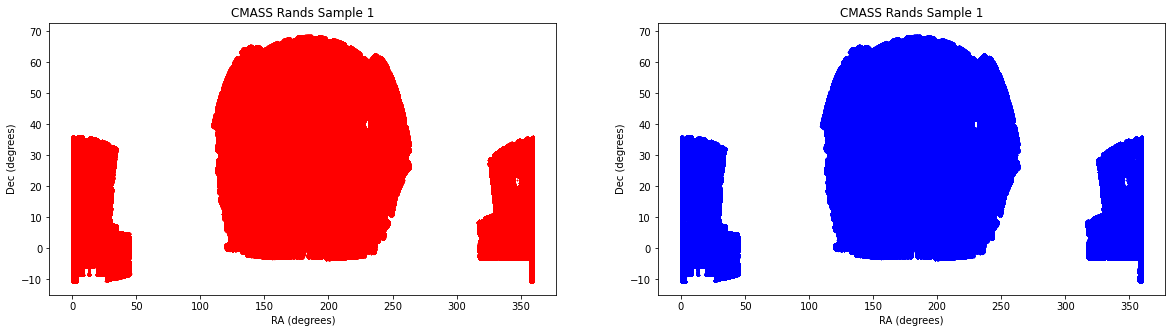

In [40]:
f3, (ax1c, ax2c) = plt.subplots(1, 2, figsize=(20, 5))

ax1c.scatter(cat_CMASS_rands_sample1.ra * 180/numpy.pi, cat_CMASS_rands_sample1.dec * 180/numpy.pi, color='red', s=0.1)
ax1c.set_xlabel('RA (degrees)')
ax1c.set_ylabel('Dec (degrees)')
ax1c.set_title('CMASS Rands Sample 1')

# Repeat in the opposite order
ax2c.scatter(cat_CMASS_rands_sample2.ra * 180/numpy.pi, cat_CMASS_rands_sample2.dec * 180/numpy.pi, color='blue', s=0.1)
ax2c.set_xlabel('RA (degrees)')
ax2c.set_ylabel('Dec (degrees)')
ax2c.set_title('CMASS Rands Sample 1')

plt.savefig(TESTING_PRODUCTS_PATH + "/CMASS rands Smaple 1 and 2")
plt.show()

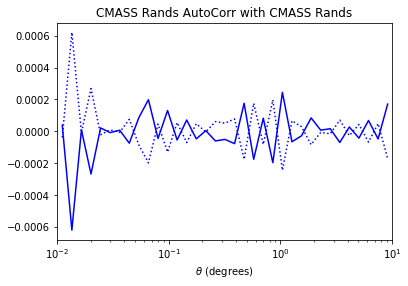

In [41]:
# Plot the autocorrelation function:

plt.plot(r_CMASS_RR, xi_CMASS_RR, color='blue')
plt.plot(r_CMASS_RR, -xi_CMASS_RR, color='blue', ls=':')
#plt.errorbar(r_CMASS_RR[xi_CMASS_RR>0], xi_CMASS_RR[xi_CMASS_RR>0], yerr=sig_CMASS_RR[xi_CMASS_RR>0], color='green', lw=0.5, ls='')
#plt.errorbar(r_CMASS_RR[xi_CMASS_RR<0], -xi_CMASS_RR[xi_CMASS_RR<0], yerr=sig_CMASS_RR[xi_CMASS_RR<0], color='green', lw=0.5, ls='')
#leg = plt.errorbar(-r_CMASS_RR, xi_CMASS_RR, yerr=sig_CMASS_RR, color='blue')
plt.xscale('log')
#plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')
#plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.title("CMASS Rands AutoCorr with CMASS Rands")

plt.savefig(TESTING_PRODUCTS_PATH + "/CMASS Rands AutoCorr with CMASS Rands")
plt.show()

In [42]:
NotesToWrite("Plotted: CMASS Rands AutoCorr with CMASS Rands")

### 5.3 AutoCorrelate LOWZ Rands with LOWZ rands

In [43]:
NotesToWrite("5.3 AutoCorrelate LOWZ Rands with LOWZ rands")

In [44]:
connLOWZRands = sqlite3.connect(DATA_PATH + 'LOWZ_rands.db')
LOWZ_DF_rands_Sample1 = pd.read_sql(qry_LOWZ_Rands_SampleLimit, con=connLOWZRands)
LOWZ_DF_rands_Sample1.to_json(DATA_PATH + "LOWZ_DF_rands")
NotesToWrite("LOWZ_DF_rands_Sample1 Database objects: " + str(len(LOWZ_DF_rands_Sample1)))
connLOWZRands.close()
LOWZ_DF_rands_Sample1.head(3)

,index,RA,DEC,Z,NZ
0,0,220.69122,23.695234,0.348653,0.000332
1,0,341.64382,22.744648,0.358111,0.000320
2,1,339.98639,13.279577,0.343342,0.000362


In [45]:
connLOWZRands = sqlite3.connect(DATA_PATH + 'LOWZ_rands.db')
LOWZ_DF_rands_Sample2 = pd.read_sql(qry_LOWZ_Rands_SampleLimit, con=connLOWZRands)
LOWZ_DF_rands_Sample2.to_json(DATA_PATH + "LOWZ_DF_rands")
NotesToWrite("LOWZ_DF_rands_Sample2 Database objects: " + str(len(LOWZ_DF_rands_Sample2)))
connLOWZRands.close()
LOWZ_DF_rands_Sample2.head(3)

,index,RA,DEC,Z,NZ
0,0,220.69122,23.695234,0.348653,0.000332
1,0,341.64382,22.744648,0.358111,0.000320
2,1,339.98639,13.279577,0.343342,0.000362


In [46]:
cat_LOWZ_rands_sample1 = treecorr.Catalog(ra=LOWZ_DF_rands_Sample1['RA'], dec=LOWZ_DF_rands_Sample1['DEC'], 
                                           ra_units='degrees', dec_units='degrees')
cat_LOWZ_rands_sample2 = treecorr.Catalog(ra=LOWZ_DF_rands_Sample2['RA'], dec=LOWZ_DF_rands_Sample2['DEC'], 
                                           ra_units='degrees', dec_units='degrees')

r_LOWZ_RR, xi_LOWZ_RR, varxi_LOWZ_RR, sig_LOWZ_RR = AutoCorrelationFunction(cat_LOWZ_rands_sample1, cat_LOWZ_rands_sample2)

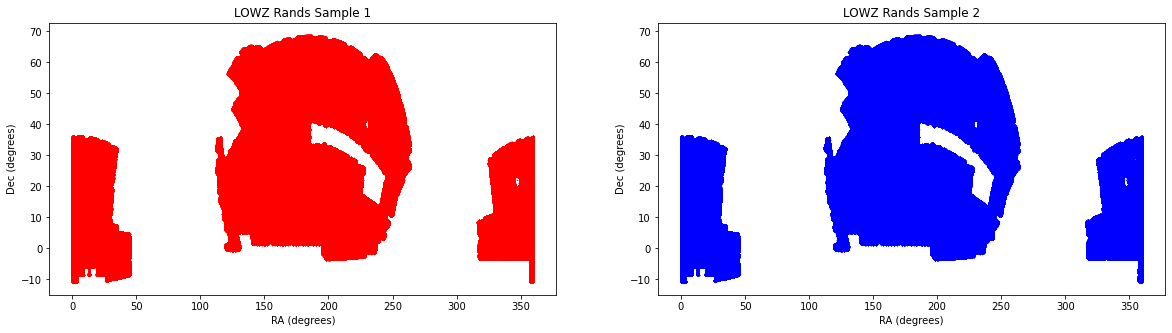

In [47]:
f3, (ax1c, ax2c) = plt.subplots(1, 2, figsize=(20, 5))

ax1c.scatter(cat_LOWZ_rands_sample1.ra * 180/numpy.pi, cat_LOWZ_rands_sample1.dec * 180/numpy.pi, color='red', s=0.1)
ax1c.set_xlabel('RA (degrees)')
ax1c.set_ylabel('Dec (degrees)')
ax1c.set_title('LOWZ Rands Sample 1')

# Repeat in the opposite order
ax2c.scatter(cat_LOWZ_rands_sample2.ra * 180/numpy.pi, cat_LOWZ_rands_sample2.dec * 180/numpy.pi, color='blue', s=0.1)
ax2c.set_xlabel('RA (degrees)')
ax2c.set_ylabel('Dec (degrees)')
ax2c.set_title('LOWZ Rands Sample 2')

plt.savefig(TESTING_PRODUCTS_PATH + "/LOWZ rands Smaple 1 and 2")
plt.show()

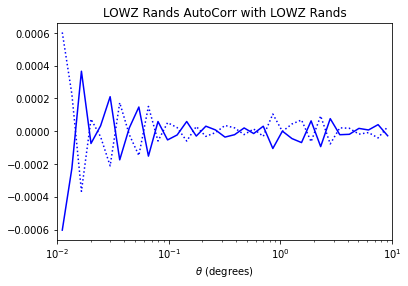

In [48]:
# Plot the autocorrelation function:

plt.plot(r_LOWZ_RR, xi_LOWZ_RR, color='blue')
plt.plot(r_LOWZ_RR, -xi_LOWZ_RR, color='blue', ls=':')
#plt.errorbar(r_LOWZ_RR[xi_LOWZ_RR>0], xi_LOWZ_RR[xi_LOWZ_RR>0], yerr=sig_LOWZ_RR[xi_LOWZ_RR>0], color='green', lw=0.5, ls='')
#plt.errorbar(r_LOWZ_RR[xi_LOWZ_RR<0], -xi_LOWZ_RR[xi_LOWZ_RR<0], yerr=sig_LOWZ_RR[xi_LOWZ_RR<0], color='green', lw=0.5, ls='')
#leg = plt.errorbar(-r_LOWZ_RR, xi_LOWZ_RR, yerr=sig_LOWZ_RR, color='blue')
plt.xscale('log')
#plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')
#plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.title("LOWZ Rands AutoCorr with LOWZ Rands")

plt.savefig(TESTING_PRODUCTS_PATH + "/LOWZ Rands AutoCorr with LOWZ Rands")
plt.show()

In [49]:
NotesToWrite("Plotted: LOWZ Rands AutoCorr with LOWZ Rands")

### 5.4 AutoCorrelate CMASS Rands with LOWZ rands

In [50]:
NotesToWrite("5.4 AutoCorrelate CMASS Rands (as data) with LOWZ rands")

In [51]:
r_CM_LZ_RR, xi_CM_LZ_RR, varxi_CM_LZ_RR, sig_CM_LZ_RR = AutoCorrelationFunction(cat_CMASS_rands_sample1, 
                                                                            cat_LOWZ_rands_sample1)

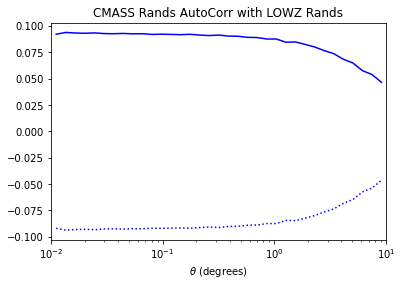

In [52]:
# Plot the autocorrelation function:

plt.plot(r_CM_LZ_RR, xi_CM_LZ_RR, color='blue')
plt.plot(r_CM_LZ_RR, -xi_CM_LZ_RR, color='blue', ls=':')
#plt.errorbar(r_CM_LZ_RR[xi_CM_LZ_RR>0], xi_CM_LZ_RR[xi_CM_LZ_RR>0], yerr=sig_CM_LZ_RR[xi_CM_LZ_RR>0], color='green', lw=0.5, ls='')
#plt.errorbar(r_CM_LZ_RR[xi_CM_LZ_RR<0], -xi_CM_LZ_RR[xi_CM_LZ_RR<0], yerr=sig_CM_LZ_RR[xi_CM_LZ_RR<0], color='green', lw=0.5, ls='')
#leg = plt.errorbar(-r_CM_LZ_RR, xi_CM_LZ_RR, yerr=sig_CM_LZ_RR, color='blue')
plt.xscale('log')
#plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')
#plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.title("CMASS Rands AutoCorr with LOWZ Rands")

plt.savefig(TESTING_PRODUCTS_PATH + "/CMASS Rands AutoCorr with LOWZ Rands")
plt.show()

In [53]:
NotesToWrite("Plotted: CMASS Rands AutoCorr with LOWZ Rands")

### 5.5 AutoCorrelate LOWZ Rands with CMASS rands

In [54]:
NotesToWrite("5.5 AutoCorrelate LOWZ Rands (as data) with CMASS rands")

In [55]:
r_LZ_CM_RR, xi_LZ_CM_RR, varxi_LZ_CM_RR, sig_LZ_CM_RR = AutoCorrelationFunction(cat_LOWZ_rands_sample1, 
                                                                            cat_CMASS_rands_sample1)

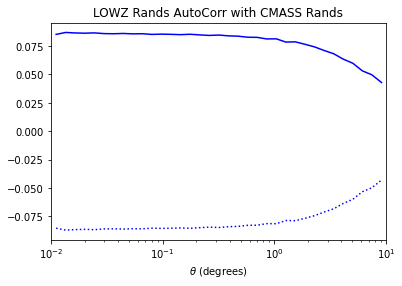

In [56]:
# Plot the autocorrelation function:

plt.plot(r_LZ_CM_RR, xi_LZ_CM_RR, color='blue')
plt.plot(r_LZ_CM_RR, -xi_LZ_CM_RR, color='blue', ls=':')
#plt.errorbar(r_LZ_CM_RR[xi_LZ_CM_RR>0], xi_LZ_CM_RR[xi_CM_LZ_RR>0], yerr=sig_LZ_CM_RR[xi_LZ_CM_RR>0], color='green', lw=0.5, ls='')
#plt.errorbar(r_LZ_CM_RR[xi_LZ_CM_RR<0], -xi_LZ_CM_RR[xi_CM_LZ_RR<0], yerr=sig_LZ_CM_RR[xi_LZ_CM_RR<0], color='green', lw=0.5, ls='')
#leg = plt.errorbar(-r_LZ_CM_RR, xi_LZ_CM_RR, yerr=sig_LZ_CM_RR, color='blue')
plt.xscale('log')
#plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')
#plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.title("LOWZ Rands AutoCorr with CMASS Rands")

plt.savefig(TESTING_PRODUCTS_PATH + "/LOWZ Rands AutoCorr with CMASS Rands")
plt.show()

In [57]:
NotesToWrite("Plotted: LOWZ Rands AutoCorr with CMASS Rands")

## 6. Cross Correlate the BOSS and PanSTARRS sets


In [58]:
NotesToWrite("6. Cross Correlate the BOSS and PanSTARRS sets")

In [59]:
# Need to get just 9 pointings from PanSTARRS: 
            
radius = (3.3/2) * numpy.pi / 180.0

maskRA_overlap = []
maskDEC_overlap = []
randoms_Lengths_overlap = []

for pointing in pointings: 
    if(pointing == "MD02"):
        continue
    else:    
        print(pointings[pointing])
        center_dec = pointings[pointing][1] * numpy.pi / 180
        center_ra = pointings[pointing][0] * numpy.pi / 180

        angular_seps = numpy.arccos(numpy.cos(numpy.pi / 2 - center_dec) * numpy.cos(numpy.pi / 2 - rand_dec_PanSTARRS) + 
                                    numpy.sin(numpy.pi / 2 - center_dec) * numpy.sin(numpy.pi / 2 - rand_dec_PanSTARRS) * 
                                    numpy.cos(center_ra - rand_ra_PanSTARRS))

        ras_in_circle = rand_ra_PanSTARRS[angular_seps < radius]
        print(len(ras_in_circle))
        ras_in_circle = ras_in_circle * 180 / numpy.pi
        decs_in_circle = rand_dec_PanSTARRS[angular_seps < radius]
        print(len(decs_in_circle))
        decs_in_circle = decs_in_circle * 180 / numpy.pi

        maskRA_overlap.extend(ras_in_circle)
        maskDEC_overlap.extend(decs_in_circle)

        randoms_Lengths_overlap.append(len(ras_in_circle))

[35.875, -4.25]
33370
33370
[130.592, 44.317]
34554
34554
[150.0, 2.2]
34466
34466
[161.917, 58.083]
33577
33577
[185.0, 47.117]
34751
34751
[213.704, 53.083]
34587
34587
[242.787, 54.95]
34696
34696
[334.188, 0.283]
34421
34421
[352.312, -0.433]
32830
32830


In [60]:
NotesToWrite("Populated pointings with randoms. Randoms per pointing: (1, 3-10):"
             + str(randoms_Lengths_overlap))

In [61]:
connPANoverlap = sqlite3.connect(DATA_PATH + 'PanSTARRS.db')
PanSTARRSNEW_GoodZ_ovelap = pd.read_sql(qry_PanSTARRS_Data_Overlap, con=connPANoverlap)
NotesToWrite("PanSTARRSNEW_GoodZ_ovelap Database (with 9 pointings) objects: " + str(len(PanSTARRSNEW_GoodZ_ovelap)))
connPANoverlap.close()
PanSTARRSNEW_GoodZ_ovelap.head(3)

,ID,DEC,RA,zSN,zHost
0,ps0909006,1.184831,333.9500,0.284,-999.0
1,ps0909010,-4.078911,37.1182,0.270,-999.0
2,ps0910017,-5.023289,35.2775,0.320,-999.0


In [62]:
cat_PanSTARRS_overlap = treecorr.Catalog(ra=PanSTARRSNEW_GoodZ_ovelap['RA'], 
                            dec=PanSTARRSNEW_GoodZ_ovelap['DEC'], ra_units='degrees', dec_units='degrees')
cat_rand_Pan_Overlap = treecorr.Catalog(ra=maskRA_overlap, dec=maskDEC_overlap, 
                            ra_units='degrees', dec_units='degrees')

nn_Pan_xCorr_BOSS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
nn_Pan_xCorr_BOSS.process(cat_PanSTARRS_overlap, cat_BOSS)

rr_Pan_xCorr_BOSS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
rr_Pan_xCorr_BOSS.process(cat_rand_Pan_Overlap, cat_rand_BOSS)

dr_Pan_xCorr_BOSS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
dr_Pan_xCorr_BOSS.process(cat_PanSTARRS_overlap, cat_rand_BOSS)

rd_Pan_xCorr_BOSS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
rd_Pan_xCorr_BOSS.process(cat_rand_BOSS, cat_PanSTARRS_overlap)

r_Pan_xCorr_BOSS = numpy.exp(nn_Pan_xCorr_BOSS.meanlogr)
xi_Pan_xCorr_BOSS, varxi_Pan_xCorr_BOSS = nn_Pan_xCorr_BOSS.calculateXi(rr_Pan_xCorr_BOSS, dr_Pan_xCorr_BOSS, rd_Pan_xCorr_BOSS)
sig_Pan_xCorr_BOSS = numpy.sqrt(varxi_Pan_xCorr_BOSS)


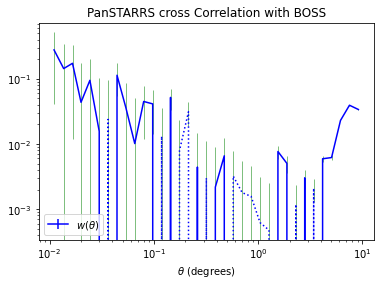

In [63]:
# Plot the Cross Correlation function:

plt.plot(r_Pan_xCorr_BOSS, xi_Pan_xCorr_BOSS, color='blue')
plt.plot(r_Pan_xCorr_BOSS, -xi_Pan_xCorr_BOSS, color='blue', ls=':')
plt.errorbar(r_Pan_xCorr_BOSS[xi_Pan_xCorr_BOSS>0], xi_Pan_xCorr_BOSS[xi_Pan_xCorr_BOSS>0], yerr=sig_Pan_xCorr_BOSS[xi_Pan_xCorr_BOSS>0], color='green', lw=0.5, ls='')
plt.errorbar(r_Pan_xCorr_BOSS[xi_Pan_xCorr_BOSS<0], -xi_Pan_xCorr_BOSS[xi_Pan_xCorr_BOSS<0], yerr=sig_Pan_xCorr_BOSS[xi_Pan_xCorr_BOSS<0], color='green', lw=0.5, ls='')
leg = plt.errorbar(-r_Pan_xCorr_BOSS, xi_Pan_xCorr_BOSS, yerr=sig_Pan_xCorr_BOSS, color='blue')
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')
plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
#plt.xlim([0.01,10])
#plt.ylim([0.0, .00001])
plt.title("PanSTARRS cross Correlation with BOSS")

plt.savefig(TESTING_PRODUCTS_PATH + "/PanSTARRS cross Correlation with BOSS")
plt.show()

In [64]:
NotesToWrite("Plotted: PanSTARRS cross Correlation with BOSS")